In [1]:
from datetime import datetime, timedelta
from tqdm import tqdm
from ray.util.client import ray

from run_simulation import run_simulations, metrics

ray.init(_memory=16 * 1024 ** 3, num_cpus=8, num_gpus=0, include_dashboard=True, ignore_reinit_error=True)

2024-10-28 12:30:40,270	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-10-28 12:30:43,286	INFO logservicer.py:103 -- New logs connection established. Total clients: 1


Python version:,3.9.18
Ray version:,2.10.0
Dashboard:,http://127.0.0.1:8265


In [2]:
from gymportal.data.ev_generators import get_standard_generator, RealWorldGenerator
from acnportal.acnsim import Linear2StageBattery
from gymportal.data.battery_generators import CustomizableBatteryGenerator
from gymportal.sim import get_charging_network, Recomputer, EvaluationSimulator, SimGenerator
from icecream import ic

charging_network = get_charging_network('simple_acn', basic_evse=True, voltage=208,
                                        network_kwargs={
                                            'station_ids': ['CA-504', 'CA-503', 'CA-502', 'CA-501'],
                                             #'station_ids': ['CA-501'],
"aggregate_cap": 32 * 208 / 1000})

# charging_network = get_charging_network('caltech', basic_evse=True, voltage=208,
#                                         network_kwargs={"transformer_cap": 40 * 32 * 208 / 1000})

battery_generator = CustomizableBatteryGenerator(voltage=208,
                                                 period=1,
                                                 battery_types=[
                                                     Linear2StageBattery],
                                                 max_power_function='normal')

ev_generator = RealWorldGenerator(battery_generator=battery_generator, site='caltech', period=1)
# ev_generator = get_standard_generator('caltech', battery_generator, seed=42)

train_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=7,
    n_intervals=46,
    start_date=datetime(2019, 1, 1),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

ic(train_generator.end_date + timedelta(days=1))

eval_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=7,
    n_intervals=1,
    start_date=train_generator.end_date + timedelta(days=1),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

ic(eval_generator.end_date + timedelta(days=1))

validation_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=14,
    n_intervals=1,
    start_date=eval_generator.end_date + timedelta(days=1),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

ic(validation_generator.end_date + timedelta(days=1))
pass

ic| train_generator.end_date + timedelta(days=1): datetime.datetime(2019, 11, 20, 0, 0)
ic| eval_generator.end_date + timedelta(days=1): datetime.datetime(2019, 11, 28, 0, 0)
ic| validation_generator.end_date + timedelta(days=1): datetime.datetime(2019, 12, 13, 0, 0)


In [3]:
from gymportal.environment import *
from extra import unplug_penalty, ranking_schedule


observation_objects = [
    charging_rates_observation_normalized(),
    percentage_of_magnitude_observation(),
    diff_pilots_charging_rates_observation_normalized(),
    cyclical_minute_observation(),
    cyclical_day_observation(),
    cyclical_month_observation(),
    cyclical_minute_observation_stay(),
    energy_delivered_observation_normalized(),
    num_active_stations_observation_normalized(),
    pilot_signals_observation_normalized(),
    cyclical_minute_observation_arrival(),
    cyclical_day_observation_arrival(),
    cyclical_month_observation_arrival(),
]

reward_objects = [
    # current_constraint_violation(),
    # soft_charging_reward(),
    constraint_charging_reward(),
    unplug_penalty(),
    # pilot_charging_rate_difference_penalty(),
]

In [4]:

train_config = {"observation_objects": observation_objects, "action_object": ranking_schedule(),
                "reward_objects": reward_objects,
                "simgenerator": train_generator,
                "meet_constraints": False}

eval_config = train_config | {'simgenerator': eval_generator}
validation_config = train_config | {'simgenerator': validation_generator}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)  # For action probabilities
        )

    def forward(self, x):
        return self.fc(x)

class ValueNetwork(nn.Module):
    def __init__(self, obs_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output for value
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
class PPOAgent(pl.LightningModule):
    
    def __init__(self, obs_dim, action_dim, lr=1e-3, gamma=0.99, clip_epsilon=0.2):
        super(PPOAgent, self).__init__()
        self.policy_net = PolicyNetwork(obs_dim, action_dim)
        self.value_net = ValueNetwork(obs_dim)
        self.lr = lr
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.optimizer = None

    def configure_optimizers(self):
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return self.optimizer

    def training_step(self, batch, batch_idx):
        obs, actions, rewards, next_obs, dones = batch

        # Compute advantages and returns
        # (You need to implement this part based on your specific method)

        # Update policy
        old_log_probs = self.policy_net(obs).gather(1, actions.unsqueeze(-1)).log()
        # Calculate ratios, clipped loss, etc.

        # Update value function
        value_loss = nn.MSELoss()(self.value_net(obs), returns)

        # Total loss and backpropagation
        loss = policy_loss + value_loss
        self.log('train_loss', loss)
        return loss

    def collect_experience(self, env):
        # Implement experience collection
        # Use the environment to collect state, action, reward, etc.
        pass


In [5]:
# from gymportal.auxilliaries.callbacks import MetricsCallback
# from ray.rllib.algorithms.ppo import PPOConfig

# # lr_schedule = [[0, 5e-5], [int(1e20), 5e-ranking]]

# config = (
#     PPOConfig()
#     .environment('single_agent_env', env_config=train_config)
#     .rollouts(num_rollout_workers=1)
#     .framework("tf2")
#     .evaluation(evaluation_num_workers=1, evaluation_interval=3)
#     .training(use_kl_loss=False, kl_coeff=0.0)
#     # .training(lr_schedule=lr_schedule)
#     # .exploration(explore=False, exploration_config={"type": "StochasticSampling"})
#     .callbacks(MetricsCallback)
# )

In [6]:
# algo = config.build()

2024-10-25 14:40:57,563	INFO trainable.py:164 -- Trainable.setup took 255.227 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-10-25 14:40:57,565	WARNING util.py:62 -- Install gputil for GPU system monitoring.


Install gputil for GPU system monitoring.


In [7]:
from gymportal.evaluation import ACNSchedule, RllibSchedule
from acnportal.algorithms import UncontrolledCharging, SortedSchedulingAlgo, last_come_first_served, \
    first_come_first_served

models = {
    #"PPO": RllibSchedule(algo),
    "FCFS": ACNSchedule(SortedSchedulingAlgo(first_come_first_served)),
    "LCFS": ACNSchedule(SortedSchedulingAlgo(last_come_first_served)),
    "Uncontrolled": ACNSchedule(UncontrolledCharging()),
}

models

{'PPO': <gymportal.evaluation.can_schedule.RllibSchedule at 0x7b63817d3dc0>,
 'FCFS': <gymportal.evaluation.can_schedule.ACNSchedule at 0x7b63817d3910>,
 'LCFS': <gymportal.evaluation.can_schedule.ACNSchedule at 0x7b63817d38e0>,
 'Uncontrolled': <gymportal.evaluation.can_schedule.ACNSchedule at 0x7b63817d3a60>}

In [8]:
df = run_simulations(models, metrics=metrics, config=eval_config, seed=42)
df

Models:  25%|██▌       | 1/4 [01:22<04:08, 82.80s/it]/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Models:  50%|█████     | 2/4 [02:47<02:47, 83.97s/it]/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Models:  75%|███████▌  | 3/4 [04:12<01:24, 84.35s/it]/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Models: 100%|██████████| 4/4 [05:34<00:00, 83.68s/it]


,SoC >= 90%,mean SoC,median SoC,prop feasible steps,prop feasible charge
Algorithms,,,,,
PPO,1.000000,0.979617,0.969948,1.000000,1.000000
FCFS,1.000000,0.979617,0.969948,1.000000,1.000000
LCFS,0.666667,0.909603,0.987236,1.000000,1.000000
Uncontrolled,1.000000,0.985379,0.987236,0.996682,0.997879


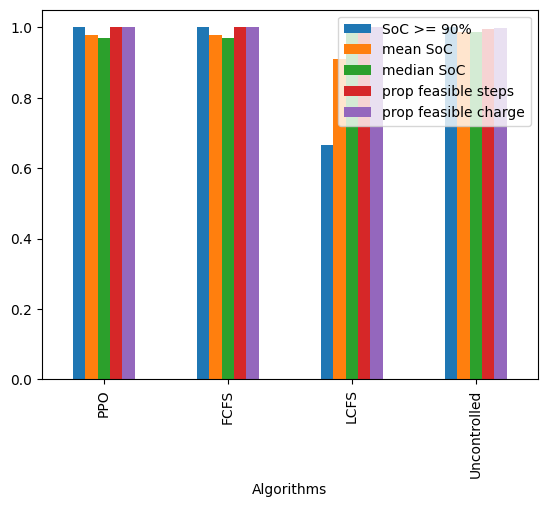

In [9]:
df.to_csv("before.csv")
ax = df.plot.bar()
fig = ax.get_figure()
fig.savefig("before.png", dpi=600)

In [10]:
# res = []

# for i in tqdm(range(12), desc='training iteration'):
#     res.append(algo.train())

#     algo.save(checkpoint_dir=f"{algo}_check")

training iteration:   0%|          | 0/12 [00:00<?, ?it/s]2024-10-25 14:59:31,121	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
/home/y/git/acn-experiments/.conda/lib/python3.9/site-packages/ray/util/client/worker.py:619: UserWarning: More than 10MB of messages have been created to schedule tasks on the server. This can be slow on Ray Client due to communication overhead over the network. If you're running many fine-grained tasks, consider running them inside a single remote function. See the section on "Too fine-grained tasks" in the Ray Design Patterns document for more details: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.f7ins22n6nyl. If your functions frequently use large objects, consider storing the objects remotely with ray.put. An example of this is shown in the "Closure capture of large / unserializable object" section of the Ray Design Patter

In [11]:
# from gymportal.plotting.plotting import plot_training

# _ = plot_training(res).savefig(f"{algo}", dpi=600)

In [ ]:
env = gym.make('Pendulum-v0')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [ ]:
ppo_agent = PPOAgent(obs_dim, action_dim)

# Implement a training loop
for epoch in range(num_epochs):
    obs = env.reset()
    done = False
    while not done:
        action_probs = ppo_agent.policy_net(torch.FloatTensor(obs))
        action = np.random.choice(action_dim, p=action_probs.detach().numpy())
        next_obs, reward, done, _ = env.step(action)

        # Store the experience
        ppo_agent.collect_experience((obs, action, reward, next_obs, done))
        obs = next_obs

    # Run training step
    ppo_agent.training_step()  # You may want to call this with a proper batch

# Finalize your training and evaluation logic


In [14]:
# algo.evaluate()

In [15]:
eval_generator = SimGenerator(
    charging_network=charging_network,
    simulation_days=1,
    n_intervals=1,
    start_date=datetime(2019, 9, 23),
    ev_generator=ev_generator,
    recomputer=Recomputer(recompute_interval=10, sparse=True),
    sim_class=EvaluationSimulator,
)

evaluation_config = train_config | {"simgenerator": eval_generator}

In [16]:
# from gymportal.evaluation import evaluate_model

# eval_sim = evaluate_model(RllibSchedule(algo), env_type=SingleAgentSimEnv, env_config=evaluation_config)

In [17]:
# from gymportal.plotting.plotting import plot_sim_evaluation

# _ = plot_sim_evaluation(eval_sim)

In [ ]:
df = run_simulations(models, metrics=metrics, config=eval_config, seed=42)
df

In [ ]:
df.to_csv("after.csv")
ax = df.plot.bar()
fig = ax.get_figure()
fig.savefig("after.png", dpi=600)